In [89]:
from bertopic import BERTopic
import pandas as pd
import os
import csv
from functools import reduce
import json
import configparser
import matplotlib.pyplot as plt
# import openai
# from bertopic.representation import OpenAI
from bertopic.representation import KeyBERTInspired

In [28]:
config = configparser.ConfigParser()
config.read("../config.ini")
#openai_key = config['DEFAULT']['openai_key']

['../config.ini']

In [29]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.2.csv'
all_countries_data = pd.read_csv(data_file, dtype={'year': str}, comment='#')
# calculate sentence lengths
all_countries_data["sentence_len"] = all_countries_data["sentence"].apply(lambda x: len(x.split()))
# cast sentence column to string
all_countries_data['sentence'] = all_countries_data['sentence'].astype(str)

In [63]:
# choose a country and year
country = ["malta"]
year = "2020"
df = pd.DataFrame(all_countries_data)
country_data = df[(df['year'] == year) & (df['country'].isin(country))]
# reset index; needed for proper parsing by BERT
country_data = country_data.reset_index(drop=True)
corpus_size = len(country_data)
number_of_words = reduce(lambda x, y: x + y, country_data["sentence_len"])

In [64]:
# show length of corpus
print(f"corpus size is {corpus_size} sentences.")
print(f"total number of words is  {number_of_words}.")
# show first 10 sentences
print(country_data.iloc[:10]['sentence'])

corpus size is 338 sentences.
total number of words is  7699.
0    The president is head of state, and is elected...
1    The president nominates the prime minister, wh...
2    In June 2017, Prime Minister Joseph Muscat won...
3    In December 2019, Muscat announced that he wou...
4    The development came after it emerged that pol...
5    Two weeks later, the European Parliament told ...
6    Members of Malta’s unicameral parliament, the ...
7    National elections are considered to be free a...
8    Snap elections were held in June 2017, about n...
9    The ruling Labour Party won 55 percent of the ...
Name: sentence, dtype: object


In [65]:
# load dictionary of topics
# strcuture [{"name": TOPIC_NAME, "words": NGRAMS_OF_KEYWORDS}, ...]
dict_file = '../data/dict_2.json'
dictionary = None
with open(dict_file, 'r') as file:
     dictionary = json.load(file)
    
def get_seed_lists(dictionary, ngram_size):
    # create list of topics wit max ngram_size
    seeds = []
    for topic in dictionary:
        seed = [w for w in topic["words"] if len(w.split()) <= ngram_size]
        seeds.append(seed)
    return seeds

In [66]:
seeds = get_seed_lists(dictionary, 1)
print(seeds)

[['elections', 'vote', 'competition', 'integrity', 'legitimacy', 'fair', 'inclusive', 'opposition', 'suffrage'], ['rights', 'freedom', 'pluralism', 'participation', 'censorship', 'media'], ['power', 'executive', 'constraints', 'constitution', 'equality'], ['corruption', 'bribery', 'embezzlement', 'fraud', 'nepotism', 'cronyism', 'kickbacks', 'graft', 'patronage', 'extortion', 'collusion', 'lobbying']]


In [67]:
# setup gpt representation model
# for openai we are block using rate limiter.
# openai.api_key = openai_key
# representation_model = OpenAI(model="gpt-3.5-turbo", chat=True)

# use other model
representation_model = KeyBERTInspired()

In [68]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# setting min_topic_size to 7 and n_grams from 1 to 3
# we need to explore these parameters. Other parameters:
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
# guided topic modeling: https://maartengr.github.io/BERTopic/getting_started/guided/guided.html
# seed_topic_list = [["corruption"],
#                   ["elections", "election", "assembly"],
#                  ["freedom", "liberty"]]
seed_topic_list = get_seed_lists(dictionary, 3)
model = BERTopic(representation_model=representation_model, seed_topic_list=seed_topic_list, verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 5, n_gram_range=(1, 3))
# model = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# fit model to our data
topics, _ = model.fit_transform(country_data.sentence)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2023-05-31 13:33:26,517 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-05-31 13:33:27,584 - BERTopic - Reduced dimensionality
2023-05-31 13:33:27,591 - BERTopic - Clustered reduced embeddings


In [69]:
# generate topic-document probability matrix
# topic_distr, _ = model.approximate_distribution(country_data.sentence, min_similarity=0)

In [77]:
# get topic information
info = model.get_topic_info()
# normalize counts
info["norm_count"] = info["Count"].apply(lambda x: x / corpus_size)
test = reduce(lambda x, y: x+y, info["norm_count"])
# test should add to 1
assert test == 1
# print topic information
print(f"Number of topics: {len(info)}")
print(info.head())

Number of topics: 18
   Topic  Count                                               Name  norm_count
0     -1     95         -1_judicial_magistrates_courts_proceedings    0.281065
1      0     37  0_european parliament resolution_law in malta_...    0.109467
2      1     33  1_commissioner for standards_standards in publ...    0.097633
3      2     20  2_reforms the venice_the venice commission_ven...    0.059172
4      3     20  3_corruption patterns_corruption allegations_t...    0.059172


In [71]:
# visualize topic words/n_grams
fig = model.visualize_barchart(top_n_topics=10)
fig.write_image("./test.png")

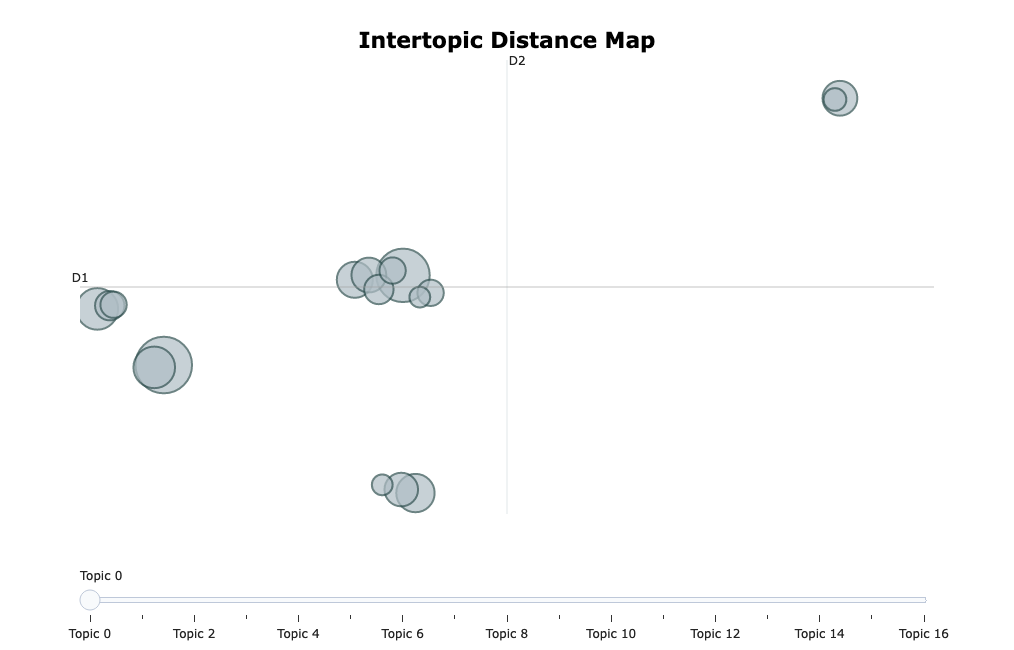

In [72]:
model.visualize_topics()

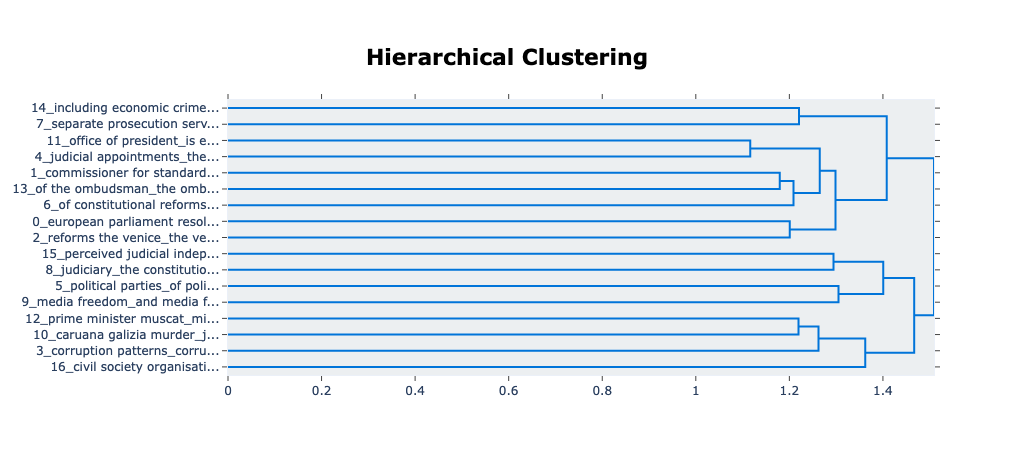

In [73]:
# visualize topic clusters
model.visualize_hierarchy(top_n_topics=30)

In [74]:
# model.visualize_distribution(topic_distr[0])

In [110]:
# search topics close to our categories
dimensions = []
for cat in dictionary:
    print(f'Closest topic to category: {cat["name"]}.')
    topics = cat["words"]
    max_similarity = 0
    
    for topic in topics:
        similar_topics, similarities = model.find_topics(topic, top_n = 1)
        # most_similar = similar_topics[0]
        if similarities[0] > max_similarity:
            max_similarity = similarities[0]
            most_similar = similar_topics[0]
            best_topic = topic
    info = model.get_topic_info(most_similar)
    # add normalized counts
    normalized_count = info["Count"][0] / corpus_size
    record = []
    record.append(cat["name"])
    record.append(most_similar)
    record.append(info["Name"][0])
    record.append(best_topic)
    record.append(max_similarity)
    record.append(normalized_count)
    record.append(model.get_topic(most_similar))
    
    
    dimensions.append(record)

    print(f"Most Similar Topic Info: {model.get_topic(most_similar)}")
    print(f"Most Similar Topic Number: {most_similar}")
    print(f"Best seed match: {best_topic}")
    print(f"Similarity Score: {max_similarity}")
    print(f"Topic normalized count: {normalized_count}")
    print(f"Topic info: {model.get_topic_info(most_similar)}")
    print("-----")


Closest topic to category: electoral.
Most Similar Topic Info: [('political parties', 0.63860047), ('of political parties', 0.61940765), ('parties given the', 0.61639774), ('parties given', 0.60702217), ('labour party', 0.5850935), ('nationalist party', 0.5528119), ('parties have difficulty', 0.54484653), ('parties', 0.5442808), ('parties have', 0.52382433), ('democratic', 0.50940657)]
Most Similar Topic Number: 5
Best seed match: political party
Similarity Score: 0.8961268663406372
Topic normalized count: 0.04437869822485207
Topic info:    Topic  Count                                               Name
0      5     15  5_political parties_of political parties_parti...
-----
Closest topic to category: participatory.
Most Similar Topic Info: [('media freedom', 0.6733966), ('and media freedom', 0.59941566), ('media freedom 2020', 0.59253395), ('freedom of expression', 0.58012646), ('provides for freedom', 0.53543377), ('media pluralism monitor', 0.5166738), ('freedom', 0.49486023), ('fre

In [111]:
# write csv
file_name = country[0] + "_" + year + "_dimenstions.csv"
with open(os.path.join("../data/", file_name), mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Dimension", "Topic_No", "Topic_Name",  "Best_Dict_Word_Match", "Similarity", "Normalized_Count", "Topic_Words"])
    for row in dimensions:
        writer.writerow(row)

In [109]:
# get document info
doc_info = model.get_document_info(country_data.sentence)
# write csv
file_name = country[0] + "_" + year + "_sentences.csv"
with open(os.path.join("../data/", file_name), mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Sentence", "Topic_Name", "Topic_No", "Probability"])
    for document, topic, name, top_n_words, prob in zip(doc_info["Document"], doc_info["Topic"], doc_info["Name"], doc_info["Top_n_words"], doc_info["Probability"]):
        writer.writerow([document, name, topic, prob])

In [117]:
# save topic information
info = model.get_topic_info()
file_name = country[0] + "_" + year + "_topics.csv"
with open(os.path.join("../data/", file_name), mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Topic_No", "Topic_Name", "Count", "Topic_Words"])
    for row in zip(info["Topic"], info["Name"], info["Count"]):
        if row[0] == -1:
            continue
        row = row + (model.get_topic(row[0]),)
        writer.writerow(row)

In [101]:
# save model
model.save(f"../data/{country[0]}_{year}")

# loading model
# model=BERTopic.load("../data/file")